CREDIT: https://pythonprogramming.net/custom-environment-reinforcement-learning-stable-baselines-3-tutorial/?completed=/saving-and-loading-reinforcement-learning-stable-baselines-3-tutorial/

https://towardsdatascience.com/snake-played-by-a-deep-reinforcement-learning-agent-53f2c4331d36

https://github.com/henniedeharder/snake/blob/master/agent_1.py

https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998

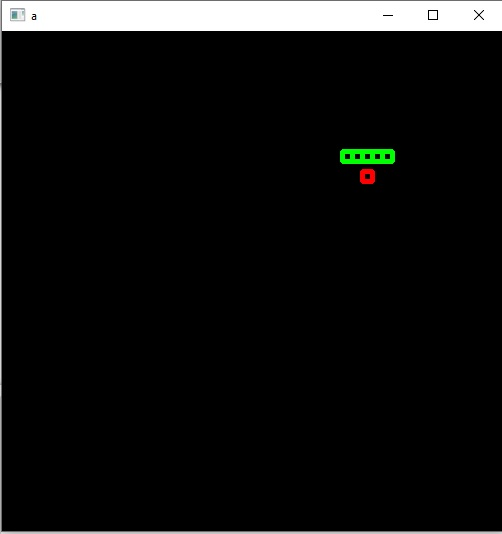

In [2]:
import gym
from gym import spaces
import numpy as np
import cv2
import random
import time
from collections import deque

# The snake game costumized enviroment

In [3]:
def collision_with_apple(apple_position):
    apple_position = [random.randrange(1,50)*10,random.randrange(1,50)*10]
    return apple_position

def collision_with_boundaries(snake_head):
    if snake_head[0]>=500 or snake_head[0]<0 or snake_head[1]>=500 or snake_head[1]<0 :
        return 1
    else:
        return 0

def collision_with_self(snake_position):
    snake_head = snake_position[0]
    if snake_head in snake_position[1:]:
        return 1
    else:
        return 0
    
class SnakeEnv(gym.Env):

    def __init__(self):
        
        super(SnakeEnv, self).__init__()
        
        self.snake_initial_length = 3
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=1, shape=(12,), dtype=np.int)
        
        
    def write_video(self):
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        self.video = cv2.VideoWriter('snake_game.mp4',fourcc,50.0,(500,500),True)
        
    def render(self, mode='human'):
        
        # Create image
        img = np.zeros((500,500,3),dtype='uint8')        
        # Display Apple
        cv2.rectangle(img,(self.apple_position[0],self.apple_position[1]),(self.apple_position[0]+10,self.apple_position[1]+10),(0,0,255),3)

        # Display Snake
        for position in self.snake_position:
            cv2.rectangle(img,(position[0],position[1]),(position[0]+10,position[1]+10),(0,255,0),3)

        # Display collision text
        if collision_with_boundaries(self.snake_head) == 1 or collision_with_self(self.snake_position) == 1:
            font = cv2.FONT_HERSHEY_SIMPLEX
            self.img = np.zeros((500,500,3),dtype='uint8')
            cv2.putText(img,'Snake length {}'.format(len(self.snake_position)),(140,250), font, 1,(255,255,255),2,cv2.LINE_AA)

        self.video.write(img)
        cv2.imshow('a',img)
        cv2.waitKey(10)
        
    def release(self):
        self.video.release()

    def step(self, action):
        
        # Change the head position based on the button direction
        if action == 1:
            self.snake_head[0] += 10
        elif action == 0:
            self.snake_head[0] -= 10
        elif action == 2:
            self.snake_head[1] += 10
        elif action == 3:
            self.snake_head[1] -= 10

        # Increase snake length on eating apple
        apple_reward = 0.0
        if self.snake_head == self.apple_position:
            self.apple_position = collision_with_apple(self.apple_position)
            self.snake_position.insert(0,list(self.snake_head))
            apple_reward = 10.0 
        else:
            self.snake_position.insert(0,list(self.snake_head))
            self.snake_position.pop()
        
        # On collision, kill the snake
        if collision_with_boundaries(self.snake_head) == 1 or collision_with_self(self.snake_position) == 1:
            self.done = True
            self.reward = -100.0 
        else:
            
            dist_to_apple = self._compute_distance_from_head(self.apple_position)
            distance_reward = 0.0
            if self.prev_distance < dist_to_apple:
                distance_reward = -1
            else:
                distance_reward =  1
            self.prev_distance = dist_to_apple
            
            self.reward = distance_reward + apple_reward

        
        observation = self._compute_observation()
        
        return observation, self.reward, self.done, {}
    
    def _compute_distance_from_head(self, position):
        return abs(self.snake_head[0]-position[0]) + abs(self.snake_head[1]-position[1])
        

    def reset(self):

        # Initial Snake and Apple position
        self.snake_position = [[250,250],[240,250],[230,250]]
        self.apple_position = [random.randrange(1,50)*10,random.randrange(1,50)*10]
        self.snake_head = [250,250]
        self.prev_distance = self._compute_distance_from_head(self.apple_position)
        
        self.prev_total_reward = 0.0
            
        self.done = False
        observation = self._compute_observation()
        
        return observation
        

    def _compute_observation(self):
        
        head_x = self.snake_head[0]
        head_y = self.snake_head[1]
        apple_x = self.apple_position[0] 
        apple_y = self.apple_position[1] 
        
        apple_above = 1 if apple_y > head_y else 0
        apple_below = 1 if apple_y < head_y else 0
        apple_left = 1 if apple_x > head_x else 0
        apple_right = 1 if apple_x < head_x else 0
        
        wall_up = 1 if head_y > 250.0 else 0
        wall_down = 1 if head_y < 250.0 else 0
        wall_right = 1 if head_x > 250.0 else 0
        wall_left = 1 if head_x < 250.0 else 0
        
        # body close
        body_up = []
        body_right = []
        body_down = []
        body_left = []
        if len(self.snake_position) > 3:
            for body in self.snake_position[3:]:
                if self._compute_distance_from_head(body) == 10:
                    if body[1] < self.snake_head[1]:
                        body_down.append(1)
                    elif body[1] > self.snake_head[1]:
                        body_up.append(1)
                    if body[0] < self.snake_head[0]:
                        body_left.append(1)
                    elif body[0] > self.snake_head[0]:
                        body_right.append(1)
                        
        if len(body_up) > 0: body_up = 1
        else: body_up = 0
            
        if len(body_right) > 0: body_right = 1
        else: body_right = 0
            
        if len(body_down) > 0: body_down = 1
        else: body_down = 0
            
        if len(body_left) > 0: body_left = 1
        else: body_left = 0

        observation = [apple_above,apple_below,apple_left,apple_right,
                       wall_up,wall_down,wall_right,wall_left,
                       body_up,body_right,body_down,body_left] 
        observation = np.array(observation)
        
        return observation

In [4]:
env = SnakeEnv()
episodes = 5

for episode in range(episodes):
    done = False
    obs = env.reset()
    while not done:
        random_action = env.action_space.sample()
        obs, reward, done, info = env.step(random_action)
        #env.render()
        print('reward',reward)

reward -100.0
reward -100.0
reward -1.0
reward -100.0
reward -1.0
reward 1.0
reward 1.0
reward -100.0
reward -1.0
reward -100.0


# Use a stable baselines 3 algorithm to compute the optimal policy

In [6]:
import gym
import os
from stable_baselines3 import PPO,A2C,DQN

d:\apps\python_3_8_6\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [7]:
env = SnakeEnv()

In [8]:
model_name = "PPO"
models_dir = "models/" + model_name
logdir = "logs"

In [9]:
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

## Save models at different iterations

In [8]:
env.reset()
if model_name =="PPO":
    model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=logdir)
elif model_name =="A2C":
    model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=logdir)
elif model_name =="DQN":
    param={}
    param['policy'] = 'MlpPolicy'
    param['env'] = env
    param['verbose'] = 1
    param['tensorboard_log'] = logdir
    
    param['exploration_initial_eps'] = 1 
    param['exploration_final_eps'] = .01
    param['exploration_fraction'] = .995
    param['gamma'] = .95
    param['batch_size'] = 500
    param['learning_rate'] = 0.00025
    param['buffer_size'] = 2500
    model = DQN(**param)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
TIMESTEPS = 10000
iters = 0
for i in range(500):
    iters += 1
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=model_name)
    model.save(f"{models_dir}/{TIMESTEPS*iters}")

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.72     |
|    ep_rew_mean     | -100     |
| time/              |          |
|    fps             | 250      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.19        |
|    ep_rew_mean          | -99.4       |
| time/                   |             |
|    fps                  | 397         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012232742 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.00247     |
|    lea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 33.8         |
|    ep_rew_mean          | -92.9        |
| time/                   |              |
|    fps                  | 1091         |
|    iterations           | 3            |
|    time_elapsed         | 5            |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0060588233 |
|    clip_fraction        | 0.0292       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.636       |
|    explained_variance   | 0.411        |
|    learning_rate        | 0.0003       |
|    loss                 | 68.6         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00347     |
|    value_loss           | 137          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 28.5         |
|    ep_rew_mean          | -81.8        |
| time/                   |              |
|    fps                  | 1058         |
|    iterations           | 4            |
|    time_elapsed         | 7            |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0049804603 |
|    clip_fraction        | 0.0445       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.419       |
|    explained_variance   | 0.836        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.4         |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.0029      |
|    value_loss           | 62.8         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 29           |
|    ep_rew_mean          | -73.8        |
| time/                   |              |
|    fps                  | 718          |
|    iterations           | 5            |
|    time_elapsed         | 14           |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0025359823 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.231       |
|    explained_variance   | 0.736        |
|    learning_rate        | 0.0003       |
|    loss                 | 69.7         |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00127     |
|    value_loss           | 127          |
------------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.1     |
|    ep_rew_mean     | -74.5    |
| time/              |          |
|    fps             | 1793     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 94208    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.5        |
|    ep_rew_mean          | -79         |
| time/                   |             |
|    fps                  | 1316        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.002602771 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.262      |
|    explained_variance   | 0.729       |
|    lea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 34.7         |
|    ep_rew_mean          | -74.7        |
| time/                   |              |
|    fps                  | 1314         |
|    iterations           | 3            |
|    time_elapsed         | 4            |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0029218053 |
|    clip_fraction        | 0.047        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.286       |
|    explained_variance   | 0.744        |
|    learning_rate        | 0.0003       |
|    loss                 | 57.5         |
|    n_updates            | 570          |
|    policy_gradient_loss | -0.000249    |
|    value_loss           | 126          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30.5         |
|    ep_rew_mean          | -69          |
| time/                   |              |
|    fps                  | 1210         |
|    iterations           | 4            |
|    time_elapsed         | 6            |
|    total_timesteps      | 141312       |
| train/                  |              |
|    approx_kl            | 0.0012844417 |
|    clip_fraction        | 0.0177       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.694        |
|    learning_rate        | 0.0003       |
|    loss                 | 122          |
|    n_updates            | 680          |
|    policy_gradient_loss | 0.000216     |
|    value_loss           | 184          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 31.6         |
|    ep_rew_mean          | -70.5        |
| time/                   |              |
|    fps                  | 1137         |
|    iterations           | 5            |
|    time_elapsed         | 9            |
|    total_timesteps      | 163840       |
| train/                  |              |
|    approx_kl            | 0.0026113302 |
|    clip_fraction        | 0.0354       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.228       |
|    explained_variance   | 0.728        |
|    learning_rate        | 0.0003       |
|    loss                 | 73.2         |
|    n_updates            | 790          |
|    policy_gradient_loss | -0.00159     |
|    value_loss           | 152          |
------------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | -72.6    |
| time/              |          |
|    fps             | 1886     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 186368   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -71.1       |
| time/                   |             |
|    fps                  | 1260        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.007770622 |
|    clip_fraction        | 0.0408      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.157      |
|    explained_variance   | 0.784       |
|    lea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 31.2         |
|    ep_rew_mean          | -68.8        |
| time/                   |              |
|    fps                  | 1354         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 208896       |
| train/                  |              |
|    approx_kl            | 0.0023073477 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.143       |
|    explained_variance   | 0.734        |
|    learning_rate        | 0.0003       |
|    loss                 | 71.5         |
|    n_updates            | 1010         |
|    policy_gradient_loss | -0.00122     |
|    value_loss           | 172          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.3        |
|    ep_rew_mean          | -71         |
| time/                   |             |
|    fps                  | 1295        |
|    iterations           | 3           |
|    time_elapsed         | 4           |
|    total_timesteps      | 231424      |
| train/                  |             |
|    approx_kl            | 0.008302339 |
|    clip_fraction        | 0.0354      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.0003      |
|    loss                 | 88.6        |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.00215    |
|    value_loss           | 156         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 33.2

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 32.1         |
|    ep_rew_mean          | -68.1        |
| time/                   |              |
|    fps                  | 1109         |
|    iterations           | 4            |
|    time_elapsed         | 7            |
|    total_timesteps      | 253952       |
| train/                  |              |
|    approx_kl            | 0.0028665452 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.119       |
|    explained_variance   | 0.806        |
|    learning_rate        | 0.0003       |
|    loss                 | 67.6         |
|    n_updates            | 1230         |
|    policy_gradient_loss | -0.0013      |
|    value_loss           | 139          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 38.1         |
|    ep_rew_mean          | -65.6        |
| time/                   |              |
|    fps                  | 1052         |
|    iterations           | 5            |
|    time_elapsed         | 9            |
|    total_timesteps      | 276480       |
| train/                  |              |
|    approx_kl            | 0.0015333768 |
|    clip_fraction        | 0.0138       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.142       |
|    explained_variance   | 0.793        |
|    learning_rate        | 0.0003       |
|    loss                 | 112          |
|    n_updates            | 1340         |
|    policy_gradient_loss | 2.41e-05     |
|    value_loss           | 144          |
------------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.5     |
|    ep_rew_mean     | -69.5    |
| time/              |          |
|    fps             | 2214     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 299008   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 34.4         |
|    ep_rew_mean          | -65.7        |
| time/                   |              |
|    fps                  | 1378         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 301056       |
| train/                  |              |
|    approx_kl            | 0.0016741192 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0976      |
|    explained_variance   | 0.787   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 29.9         |
|    ep_rew_mean          | -71.8        |
| time/                   |              |
|    fps                  | 1423         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 321536       |
| train/                  |              |
|    approx_kl            | 0.0011111906 |
|    clip_fraction        | 0.0128       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.085       |
|    explained_variance   | 0.796        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.4         |
|    n_updates            | 1560         |
|    policy_gradient_loss | -0.000779    |
|    value_loss           | 133          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 29.5         |
|    ep_rew_mean          | -72.6        |
| time/                   |              |
|    fps                  | 1277         |
|    iterations           | 3            |
|    time_elapsed         | 4            |
|    total_timesteps      | 344064       |
| train/                  |              |
|    approx_kl            | 0.0011327371 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.104       |
|    explained_variance   | 0.8          |
|    learning_rate        | 0.0003       |
|    loss                 | 63.5         |
|    n_updates            | 1670         |
|    policy_gradient_loss | -0.00103     |
|    value_loss           | 135          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 31.6         |
|    ep_rew_mean          | -68.9        |
| time/                   |              |
|    fps                  | 1148         |
|    iterations           | 4            |
|    time_elapsed         | 7            |
|    total_timesteps      | 366592       |
| train/                  |              |
|    approx_kl            | 0.0015018461 |
|    clip_fraction        | 0.0162       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.103       |
|    explained_variance   | 0.799        |
|    learning_rate        | 0.0003       |
|    loss                 | 78.1         |
|    n_updates            | 1780         |
|    policy_gradient_loss | -0.000403    |
|    value_loss           | 136          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.3         |
|    ep_rew_mean          | -33.8        |
| time/                   |              |
|    fps                  | 1129         |
|    iterations           | 5            |
|    time_elapsed         | 9            |
|    total_timesteps      | 389120       |
| train/                  |              |
|    approx_kl            | 0.0038085328 |
|    clip_fraction        | 0.0183       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0773      |
|    explained_variance   | 0.478        |
|    learning_rate        | 0.0003       |
|    loss                 | 141          |
|    n_updates            | 1890         |
|    policy_gradient_loss | -0.00369     |
|    value_loss           | 301          |
------------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 84.2     |
|    ep_rew_mean     | 2.61     |
| time/              |          |
|    fps             | 2193     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 411648   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 92.5       |
|    ep_rew_mean          | 12.3       |
| time/                   |            |
|    fps                  | 1328       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 413696     |
| train/                  |            |
|    approx_kl            | 0.01032817 |
|    clip_fraction        | 0.0274     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0929    |
|    explained_variance   | 0.187      |
|    learning_rate     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 132          |
|    ep_rew_mean          | 60.7         |
| time/                   |              |
|    fps                  | 1299         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 434176       |
| train/                  |              |
|    approx_kl            | 0.0033089905 |
|    clip_fraction        | 0.0114       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0612      |
|    explained_variance   | 0.436        |
|    learning_rate        | 0.0003       |
|    loss                 | 238          |
|    n_updates            | 2110         |
|    policy_gradient_loss | -0.00145     |
|    value_loss           | 587          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 208          |
|    ep_rew_mean          | 156          |
| time/                   |              |
|    fps                  | 1208         |
|    iterations           | 3            |
|    time_elapsed         | 5            |
|    total_timesteps      | 456704       |
| train/                  |              |
|    approx_kl            | 0.0011802244 |
|    clip_fraction        | 0.00923      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0447      |
|    explained_variance   | 0.268        |
|    learning_rate        | 0.0003       |
|    loss                 | 155          |
|    n_updates            | 2220         |
|    policy_gradient_loss | -0.00101     |
|    value_loss           | 607          |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 179         |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 1190        |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 479232      |
| train/                  |             |
|    approx_kl            | 0.004064882 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0502     |
|    explained_variance   | 0.378       |
|    learning_rate        | 0.0003      |
|    loss                 | 521         |
|    n_updates            | 2330        |
|    policy_gradient_loss | -0.00173    |
|    value_loss           | 873         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 177   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 175          |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 1107         |
|    iterations           | 5            |
|    time_elapsed         | 9            |
|    total_timesteps      | 501760       |
| train/                  |              |
|    approx_kl            | 0.0064376355 |
|    clip_fraction        | 0.0223       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0405      |
|    explained_variance   | 0.336        |
|    learning_rate        | 0.0003       |
|    loss                 | 344          |
|    n_updates            | 2440         |
|    policy_gradient_loss | -0.00183     |
|    value_loss           | 545          |
------------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 171      |
|    ep_rew_mean     | 110      |
| time/              |          |
|    fps             | 2237     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 524288   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 179          |
|    ep_rew_mean          | 121          |
| time/                   |              |
|    fps                  | 1396         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 526336       |
| train/                  |              |
|    approx_kl            | 0.0012930539 |
|    clip_fraction        | 0.00391      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0288      |
|    explained_variance   | 0.354   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 199          |
|    ep_rew_mean          | 141          |
| time/                   |              |
|    fps                  | 1437         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 546816       |
| train/                  |              |
|    approx_kl            | 0.0019865844 |
|    clip_fraction        | 0.00566      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0264      |
|    explained_variance   | 0.188        |
|    learning_rate        | 0.0003       |
|    loss                 | 294          |
|    n_updates            | 2660         |
|    policy_gradient_loss | -0.000841    |
|    value_loss           | 614          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 206          |
|    ep_rew_mean          | 152          |
| time/                   |              |
|    fps                  | 1245         |
|    iterations           | 3            |
|    time_elapsed         | 4            |
|    total_timesteps      | 569344       |
| train/                  |              |
|    approx_kl            | 0.0013861354 |
|    clip_fraction        | 0.0133       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0462      |
|    explained_variance   | 0.381        |
|    learning_rate        | 0.0003       |
|    loss                 | 315          |
|    n_updates            | 2770         |
|    policy_gradient_loss | -0.00116     |
|    value_loss           | 880          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 187         |
|    ep_rew_mean          | 130         |
| time/                   |             |
|    fps                  | 1095        |
|    iterations           | 4           |
|    time_elapsed         | 7           |
|    total_timesteps      | 591872      |
| train/                  |             |
|    approx_kl            | 0.004151256 |
|    clip_fraction        | 0.0269      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0549     |
|    explained_variance   | 0.285       |
|    learning_rate        | 0.0003      |
|    loss                 | 135         |
|    n_updates            | 2880        |
|    policy_gradient_loss | -0.00036    |
|    value_loss           | 717         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 183 

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 231           |
|    ep_rew_mean          | 183           |
| time/                   |               |
|    fps                  | 1197          |
|    iterations           | 5             |
|    time_elapsed         | 8             |
|    total_timesteps      | 614400        |
| train/                  |               |
|    approx_kl            | 0.00033347047 |
|    clip_fraction        | 0.0022        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0228       |
|    explained_variance   | 0.443         |
|    learning_rate        | 0.0003        |
|    loss                 | 281           |
|    n_updates            | 2990          |
|    policy_gradient_loss | 7.5e-05       |
|    value_loss           | 641           |
-------------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/          

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 214      |
|    ep_rew_mean     | 163      |
| time/              |          |
|    fps             | 2003     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 636928   |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 219           |
|    ep_rew_mean          | 168           |
| time/                   |               |
|    fps                  | 1271          |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 638976        |
| train/                  |               |
|    approx_kl            | 0.00044486098 |
|    clip_fraction        | 0.0121        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0599       |
|    explained_varianc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 220          |
|    ep_rew_mean          | 171          |
| time/                   |              |
|    fps                  | 1354         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 659456       |
| train/                  |              |
|    approx_kl            | 0.0010937054 |
|    clip_fraction        | 0.0357       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0496      |
|    explained_variance   | 0.354        |
|    learning_rate        | 0.0003       |
|    loss                 | 120          |
|    n_updates            | 3210         |
|    policy_gradient_loss | -0.000307    |
|    value_loss           | 490          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 188          |
|    ep_rew_mean          | 130          |
| time/                   |              |
|    fps                  | 1085         |
|    iterations           | 3            |
|    time_elapsed         | 5            |
|    total_timesteps      | 681984       |
| train/                  |              |
|    approx_kl            | 0.0010383055 |
|    clip_fraction        | 0.0114       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0599      |
|    explained_variance   | 0.408        |
|    learning_rate        | 0.0003       |
|    loss                 | 323          |
|    n_updates            | 3320         |
|    policy_gradient_loss | -0.00119     |
|    value_loss           | 853          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 208          |
|    ep_rew_mean          | 157          |
| time/                   |              |
|    fps                  | 952          |
|    iterations           | 4            |
|    time_elapsed         | 8            |
|    total_timesteps      | 704512       |
| train/                  |              |
|    approx_kl            | 0.0012129068 |
|    clip_fraction        | 0.0113       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0542      |
|    explained_variance   | 0.48         |
|    learning_rate        | 0.0003       |
|    loss                 | 245          |
|    n_updates            | 3430         |
|    policy_gradient_loss | -2.08e-05    |
|    value_loss           | 702          |
------------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 268          |
|    ep_rew_mean          | 231          |
| time/                   |              |
|    fps                  | 1136         |
|    iterations           | 5            |
|    time_elapsed         | 9            |
|    total_timesteps      | 727040       |
| train/                  |              |
|    approx_kl            | 0.0007873451 |
|    clip_fraction        | 0.00327      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0165      |
|    explained_variance   | 0.296        |
|    learning_rate        | 0.0003       |
|    loss                 | 205          |
|    n_updates            | 3540         |
|    policy_gradient_loss | -0.000532    |
|    value_loss           | 608          |
------------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 342      |
|    ep_rew_mean     | 323      |
| time/              |          |
|    fps             | 2303     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 749568   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 355          |
|    ep_rew_mean          | 340          |
| time/                   |              |
|    fps                  | 1378         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 751616       |
| train/                  |              |
|    approx_kl            | 0.0007162679 |
|    clip_fraction        | 0.0119       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0252      |
|    explained_variance   | 0.115   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 388          |
|    ep_rew_mean          | 382          |
| time/                   |              |
|    fps                  | 1436         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 772096       |
| train/                  |              |
|    approx_kl            | 0.0012397455 |
|    clip_fraction        | 0.00264      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.00862     |
|    explained_variance   | 0.018        |
|    learning_rate        | 0.0003       |
|    loss                 | 330          |
|    n_updates            | 3760         |
|    policy_gradient_loss | -0.00108     |
|    value_loss           | 553          |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 455           |
|    ep_rew_mean          | 465           |
| time/                   |               |
|    fps                  | 1209          |
|    iterations           | 3             |
|    time_elapsed         | 5             |
|    total_timesteps      | 794624        |
| train/                  |               |
|    approx_kl            | 0.00045608828 |
|    clip_fraction        | 0.00625       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0179       |
|    explained_variance   | 0.199         |
|    learning_rate        | 0.0003        |
|    loss                 | 455           |
|    n_updates            | 3870          |
|    policy_gradient_loss | -0.000505     |
|    value_loss           | 898           |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 476           |
|    ep_rew_mean          | 491           |
| time/                   |               |
|    fps                  | 1154          |
|    iterations           | 4             |
|    time_elapsed         | 7             |
|    total_timesteps      | 817152        |
| train/                  |               |
|    approx_kl            | 0.00012737958 |
|    clip_fraction        | 0.00288       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0152       |
|    explained_variance   | 0.382         |
|    learning_rate        | 0.0003        |
|    loss                 | 81.1          |
|    n_updates            | 3980          |
|    policy_gradient_loss | 0.000435      |
|    value_loss           | 493           |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 449         |
|    ep_rew_mean          | 458         |
| time/                   |             |
|    fps                  | 1146        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 839680      |
| train/                  |             |
|    approx_kl            | 0.002258315 |
|    clip_fraction        | 0.0127      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0167     |
|    explained_variance   | 0.493       |
|    learning_rate        | 0.0003      |
|    loss                 | 401         |
|    n_updates            | 4090        |
|    policy_gradient_loss | 6.61e-05    |
|    value_loss           | 516         |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 440  

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 447      |
|    ep_rew_mean     | 455      |
| time/              |          |
|    fps             | 2229     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 862208   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 453          |
|    ep_rew_mean          | 462          |
| time/                   |              |
|    fps                  | 1453         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 864256       |
| train/                  |              |
|    approx_kl            | 0.0001431556 |
|    clip_fraction        | 0.000684     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0047      |
|    explained_variance   | -0.346  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 518        |
|    ep_rew_mean          | 541        |
| time/                   |            |
|    fps                  | 1387       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 884736     |
| train/                  |            |
|    approx_kl            | 0.00897268 |
|    clip_fraction        | 0.00151    |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.00828   |
|    explained_variance   | 0.311      |
|    learning_rate        | 0.0003     |
|    loss                 | 45.2       |
|    n_updates            | 4310       |
|    policy_gradient_loss | -0.00145   |
|    value_loss           | 108        |
----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 522           |
|    ep

In [10]:
env.reset()

model_path = f"{models_dir}/880000.zip"

if model_name =="PPO":
    model = PPO.load(model_path, env=env)
elif model_name =="A2C":
    model = A2C.load(model_path, env=env)

episodes = 3
env.write_video()
for ep in range(episodes):
    obs = env.reset()
    done = False
    while not done:
        # pass observation to model to get predicted action
        action, _states = model.predict(obs)
        # pass action to env and get info back
        obs, rewards, done, info = env.step(action)
        
        # show the environment on the screen
        env.render()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
cv2.destroyAllWindows()

In [12]:
env.release()